In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize

pd.set_option("display.max_columns", None)

# Téléchargement des données

In [5]:
tickers = ["PSI", "IYW", "RING", "PICK", "NLR", "UTES", "LIT", "NANR", "GUNR", "XCEM", "PTLC", "FXU"]
start_date = "2015-01-01"

data = yf.download(tickers=tickers, start=start_date, auto_adjust=True, progress=False)

In [6]:
close_prices = data["Close"].dropna()

In [7]:
close_prices

Ticker,FXU,GUNR,IYW,LIT,NANR,NLR,PICK,PSI,PTLC,RING,UTES,XCEM
Date,,,,,,,,,,,,
2015-12-18,16.569326,15.826995,24.743832,16.902910,19.121031,33.434586,10.725579,8.048889,20.466742,9.423356,21.083975,14.977438
2015-12-21,16.682297,15.882770,24.977720,16.920214,18.894258,33.416504,10.887070,8.157701,20.620087,9.601748,20.755669,14.329371
2015-12-22,16.817871,16.105879,25.134436,17.266411,19.259872,33.853420,11.169675,8.186502,20.746368,9.636728,20.859770,14.449601
2015-12-23,17.178965,16.682367,25.335585,17.560684,20.045071,34.184875,11.506112,8.231308,21.025991,9.846604,21.235319,14.449601
2015-12-24,17.163731,16.667795,25.315878,17.482780,20.099062,34.440990,11.721430,8.295314,21.025991,10.056476,21.212099,14.728182
...,...,...,...,...,...,...,...,...,...,...,...,...
2026-01-09,45.029999,47.360001,201.750000,68.209999,71.970001,140.419998,54.430000,88.870003,56.570000,79.480003,78.639999,39.980000
2026-01-12,45.080002,47.810001,202.419998,70.000000,72.570000,143.059998,55.590000,89.099998,56.660000,82.339996,78.839996,40.259998
2026-01-13,45.389999,48.299999,201.899994,70.510002,73.370003,140.839996,55.660000,89.660004,56.564999,83.010002,79.529999,40.040001


In [8]:
returns = close_prices.pct_change().dropna()

momentum_1m = close_prices.pct_change(21)
momentum_3m = close_prices.pct_change(63)
momentum_6m = close_prices.pct_change(126)

vol_1m = returns.rolling(21).std()
vol_3m = returns.rolling(63).std()

# Return sur 22 jours au lieu de 1 jour
return_22d = close_prices.pct_change(22)

In [9]:
def max_drawdown(series):
    cumulative = (1 + series).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    return drawdown.min()

drawdown_6m = returns.rolling(126).apply(max_drawdown, raw=False)


In [10]:
corr_3m = returns.rolling(63).corr().groupby(level=0).mean()
corr_6m = returns.rolling(126).corr().groupby(level=0).mean()

In [11]:
features = pd.concat({
    "return_22d": return_22d,
    "momentum_1m": momentum_1m,
    "momentum_3m": momentum_3m,
    "momentum_6m": momentum_6m,
    "vol_1m": vol_1m,
    "vol_3m": vol_3m,
    "max_dd_6m": drawdown_6m,
    "corr_3m": corr_3m,
    "corr_6m": corr_6m
}, axis=1).dropna()

features

return_22d                                                    \
Ticker            FXU      GUNR       IYW       LIT      NANR       NLR   
Date                                                                      
2016-06-21   0.054488  0.044930  0.036096  0.096245  0.046489  0.037307   
2016-06-22   0.045380  0.040429  0.017811  0.073900  0.043500  0.035843   
2016-06-23   0.063147  0.062660  0.034333  0.089286  0.050111  0.038388   
2016-06-24   0.040907  0.002902 -0.030604  0.018747  0.038468  0.012051   
2016-06-27   0.042955 -0.033350 -0.063022 -0.036417 -0.006605  0.013757   
...               ...       ...       ...       ...       ...       ...   
2026-01-09   0.011291  0.066081 -0.011092  0.071857  0.097186  0.070355   
2026-01-12   0.011062  0.071899 -0.008828  0.092963  0.097031  0.087808   
2026-01-13   0.020286  0.071671 -0.013451  0.084046  0.091842  0.077483   
2026-01-14   0.026048  0.080138 -0.021139  0.087237  0.097898  0.071890   
2026-01-15   0.031501  0.084176  0.016050  0.119361  0.093894  0.150444   

                                                                        \
Ticker          PICK       PSI      PTLC      RING      UTES      XCEM   
Date                                                                     
2016-06-21  0.067439  0.106654  0.025842  0.030039  0.071132  0.082776   
2016-06-22  0.056638  0.062653  0.015124  0.058893  0.065491  0.071393   
2016-06-23  0.102143  0.073057  0.032184  0.055436  0.058645  0.100397   
2016-06-24  0.007131 -0.008297 -0.018124  0.189129  0.065104  0.034321   
2016-06-27 -0.046491 -0.057847 -0.041911  0.182041  0.071425  0.034321   
...              ...       ...       ...       ...       ...       ...   
2026-01-09  0.130956  0.083849  0.017552  0.174733  0.000252  0.083146   
2026-01-12  0.159089  0.085198  0.019897  0.179711  0.004575  0.084878   
2026-01-13  0.134469  0.063902  0.011341  0.175239  0.009655  0.067163   
2026-01-14  0.148899  0.065758  0.004291  0.135471 -0.003402  0.081605   
2026-01-15  0.163913  0.163208  0.020101  0.148608  0.039743  0.104418   

           momentum_1m                                                    \
Ticker             FXU      GUNR       IYW       LIT      NANR       NLR   
Date                                                                       
2016-06-21    0.050280  0.042027  0.022442  0.085006  0.041326  0.026087   
2016-06-22    0.054639  0.037957  0.018595  0.068878  0.038059  0.035843   
2016-06-23    0.052134  0.059723  0.012691  0.091606  0.064147  0.035095   
2016-06-24    0.042153 -0.014611 -0.038937  0.000837  0.014192  0.013122   
2016-06-27    0.032658 -0.032599 -0.065642 -0.039632 -0.002669  0.002931   
...                ...       ...       ...       ...       ...       ...   
2026-01-09    0.009941  0.061810 -0.012109  0.065014  0.087961  0.067734   
2026-01-12    0.013318  0.060799 -0.010910  0.076205  0.079937  0.094467   
2026-01-13    0.015754  0.059302 -0.008170  0.085544  0.076621  0.044957   
2026-01-14    0.024352  0.086050  0.003958  0.108686  0.105120  0.140849   
2026-01-15    0.024179  0.087510  0.025659  0.123937  0.099730  0.180365   

                                                                        \
Ticker          PICK       PSI      PTLC      RING      UTES      XCEM   
Date                                                                     
2016-06-21  0.062959  0.068599  0.018790  0.031038  0.071132  0.075260   
2016-06-22  0.058860  0.052255  0.018391  0.067174  0.059495  0.074055   
2016-06-23  0.102143  0.046436  0.017218  0.123529  0.058645  0.093333   
2016-06-24 -0.017660 -0.011693 -0.023434  0.163699  0.062943  0.034321   
2016-06-27 -0.053288 -0.063192 -0.042342  0.180839  0.062796  0.034321   
...              ...       ...       ...       ...       ...       ...   
2026-01-09  0.134902  0.082396  0.018277  0.138735  0.002027  0.077333   
2026-01-12  0.133042  0.057257  0.013040  0.165754  0.000895  0.073026   
2026-01-13  0.122087  0.067067  0.009377  0.

In [12]:
features.columns = [f"{feat}_{ticker}" for feat, ticker in features.columns]

In [13]:
features = features.reset_index()
dataset = features.melt(id_vars="Date", var_name="Ticker_Feature", value_name="value")
dataset[["Feature", "Ticker"]] = dataset["Ticker_Feature"].str.rsplit("_", n=1, expand=True)
dataset = dataset.pivot_table(index=["Date", "Ticker"], columns="Feature", values="value").reset_index()

In [14]:
dataset = dataset.dropna().reset_index(drop=True)

In [15]:
dataset.head(20)

Feature,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,return_22d,vol_1m,vol_3m
0,2016-06-21,FXU,0.371799,0.482133,-0.059031,0.050280,0.039248,0.216054,0.054488,0.005587,0.007507
1,2016-06-21,GUNR,0.535929,0.583935,-0.158148,0.042027,0.061409,0.214562,0.044930,0.011395,0.013709
2,2016-06-21,IYW,0.387734,0.462349,-0.144699,0.022442,-0.009024,0.011724,0.036096,0.007017,0.008022
3,2016-06-21,LIT,0.505038,0.539793,-0.156479,0.085006,0.165137,0.303661,0.096245,0.011497,0.012132
4,2016-06-21,NANR,0.459487,0.506045,-0.177220,0.041326,0.125673,0.362251,0.046489,0.011997,0.016568
5,2016-06-21,NLR,0.373736,0.432842,-0.062774,0.026087,0.011499,0.090033,0.037307,0.005790,0.008028
6,2016-06-21,PICK,0.520314,0.545708,-0.211251,0.062959,0.038974,0.271016,0.067439,0.019890,0.023194
7,2016-06-21,PSI,0.324797,0.458628,-0.177376,0.068599,0.065231,0.074972,0.106654,0.008240,0.011297
8,2016-06-21,PTLC,0.496474,0.392547,-0.081127,0.018790,0.026790,-0.017777,0.025842,0.005278,0.005879
9,2016-06-21,RING,0.275621,0.187817,-0.146865,0.031038,0.205216,0.972902,0.030039,0.034132,0.034701


In [17]:
metadata = pd.read_excel("/Users/kawtarmerno/code/merkawt-cell/dynamic_portfolio_optimizer/raw_data/etf_portfolio_db.xlsx", sheet_name="Qualified_ETFs")

In [19]:
dataset_merged = dataset.merge(metadata[["Ticker", "Region (General)_x"]], on="Ticker", how="left")

In [20]:
dataset_merged.head(10)

,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,return_22d,vol_1m,vol_3m,Region (General)_x
0,2016-06-21,FXU,0.371799,0.482133,-0.059031,0.050280,0.039248,0.216054,0.054488,0.005587,0.007507,North America
1,2016-06-21,GUNR,0.535929,0.583935,-0.158148,0.042027,0.061409,0.214562,0.044930,0.011395,0.013709,Developed Markets
2,2016-06-21,IYW,0.387734,0.462349,-0.144699,0.022442,-0.009024,0.011724,0.036096,0.007017,0.008022,North America
3,2016-06-21,LIT,0.505038,0.539793,-0.156479,0.085006,0.165137,0.303661,0.096245,0.011497,0.012132,Developed Markets
4,2016-06-21,NANR,0.459487,0.506045,-0.177220,0.041326,0.125673,0.362251,0.046489,0.011997,0.016568,North America
5,2016-06-21,NLR,0.373736,0.432842,-0.062774,0.026087,0.011499,0.090033,0.037307,0.005790,0.008028,Developed Markets
6,2016-06-21,PICK,0.520314,0.545708,-0.211251,0.062959,0.038974,0.271016,0.067439,0.019890,0.023194,Developed Markets
7,2016-06-21,PSI,0.324797,0.458628,-0.177376,0.068599,0.065231,0.074972,0.106654,0.008240,0.011297,North America
8,2016-06-21,PTLC,0.496474,0.392547,-0.081127,0.018790,0.026790,-0.017777,0.025842,0.005278,0.005879,North America
9,2016-06-21,RING,0.275621,0.187817,-0.146865,0.031038,0.205216,0.972902,0.030039,0.034132,0.034701,Developed Markets


# Vérification

In [21]:
df = dataset_merged
df.shape

(28884, 12)

In [22]:
df.duplicated(subset=["Date", "Ticker"]).sum()

0

In [23]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.dtypes

Date                  datetime64[ns]
Ticker                        object
corr_3m                      float64
corr_6m                      float64
max_dd_6m                    float64
momentum_1m                  float64
momentum_3m                  float64
momentum_6m                  float64
return_22d                   float64
vol_1m                       float64
vol_3m                       float64
Region (General)_x            object
dtype: object

In [24]:
df.isna().mean().sort_values(ascending=False)

Date                  0.0
Ticker                0.0
corr_3m               0.0
corr_6m               0.0
max_dd_6m             0.0
momentum_1m           0.0
momentum_3m           0.0
momentum_6m           0.0
return_22d            0.0
vol_1m                0.0
vol_3m                0.0
Region (General)_x    0.0
dtype: float64

In [20]:
df.groupby("Ticker")["Date"].apply(lambda x: x.duplicated().sum())

Ticker
FXU     0
GUNR    0
IYW     0
LIT     0
NANR    0
NLR     0
PICK    0
PSI     0
PTLC    0
RING    0
UTES    0
XCEM    0
Name: Date, dtype: int64

In [25]:
def count_date_gaps(x):
    dates = x.sort_values()
    diffs = dates.diff().dt.days
    return (diffs > 5).sum()

df.groupby("Ticker")["Date"].apply(count_date_gaps).sort_values(ascending=False)

Ticker
FXU     0
GUNR    0
IYW     0
LIT     0
NANR    0
NLR     0
PICK    0
PSI     0
PTLC    0
RING    0
UTES    0
XCEM    0
Name: Date, dtype: int64

In [26]:
df.groupby("Ticker")["Date"].nunique().sort_values()

Ticker
FXU     2407
GUNR    2407
IYW     2407
LIT     2407
NANR    2407
NLR     2407
PICK    2407
PSI     2407
PTLC    2407
RING    2407
UTES    2407
XCEM    2407
Name: Date, dtype: int64

,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,return_22d,vol_1m,vol_3m,Region (General)_x
0,2016-06-21,FXU,0.371799,0.482133,-0.059031,0.050280,0.039248,0.216054,0.054487,0.005587,0.007507,North America
1,2016-06-21,GUNR,0.535929,0.583935,-0.158148,0.042026,0.061409,0.214562,0.044930,0.011395,0.013709,Developed Markets
2,2016-06-21,IYW,0.387730,0.462348,-0.144699,0.022442,-0.009024,0.011725,0.036096,0.007017,0.008022,North America
3,2016-06-21,LIT,0.505037,0.539793,-0.156479,0.085006,0.165138,0.303661,0.096245,0.011497,0.012132,Developed Markets
4,2016-06-21,NANR,0.459488,0.506046,-0.177220,0.041326,0.125673,0.362250,0.046489,0.011997,0.016568,North America
...,...,...,...,...,...,...,...,...,...,...,...,...
28855,2026-01-13,PSI,0.618389,0.569410,-0.130407,0.071569,0.246973,0.464390,0.068390,0.024292,0.022949,North America
28856,2026-01-13,PTLC,0.587227,0.582867,-0.050801,0.008217,0.046852,0.117107,0.010179,0.005772,0.006975,North America
28857,2026-01-13,RING,0.529671,0.480764,-0.192212,0.137378,0.244687,0.928393,0.181752,0.023826,0.029552,Developed Markets
28858,2026-01-13,UTES,0.491525,0.445638,-0.122158,-0.005586,-0.072610,0.073323,0.011496,0.015616,0.013464,North America


In [28]:
from sklearn.preprocessing import RobustScaler, LabelEncoder

df1 = df.copy()

numeric_features = ['corr_3m', 'corr_6m', 'max_dd_6m', 'momentum_1m', 'momentum_3m', 'momentum_6m', 'vol_1m', 'vol_3m']

scaler = RobustScaler()
df1[numeric_features] = scaler.fit_transform(df1[numeric_features])

le = LabelEncoder()
df1['Region_Encoded'] = le.fit_transform(df1['Region (General)_x'])

print(f"\nEncoding:")
for i, region in enumerate(le.classes_):
    print(f"  {region} -> {i}")

df1.head(10)


Encoding:
  Developed Markets -> 0
  Emerging Markets -> 1
  North America -> 2


,Date,Ticker,corr_3m,corr_6m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,return_22d,vol_1m,vol_3m,Region (General)_x,Region_Encoded
0,2016-06-21,FXU,-0.739536,-0.267571,0.567378,0.509733,0.033906,0.852074,0.054488,-0.724951,-0.572973,North America,2
1,2016-06-21,GUNR,0.114184,0.364242,-0.448420,0.394455,0.220185,0.843712,0.044930,-0.049553,0.174655,Developed Markets,0
2,2016-06-21,IYW,-0.656653,-0.390355,-0.310588,0.120900,-0.371868,-0.293461,0.036096,-0.558646,-0.510931,North America,2
3,2016-06-21,LIT,-0.046498,0.090283,-0.431322,0.994789,1.092123,1.343227,0.096245,-0.037726,-0.015474,Developed Markets,0
4,2016-06-21,NANR,-0.283431,-0.119168,-0.643883,0.384666,0.760388,1.671699,0.046489,0.020417,0.519292,North America,2
5,2016-06-21,NLR,-0.729463,-0.573483,0.529025,0.171810,-0.199350,0.145559,0.037307,-0.701300,-0.510120,Developed Markets,0
6,2016-06-21,PICK,0.032961,0.126989,-0.992656,0.686841,0.031604,1.160211,0.067439,0.938239,1.317933,Developed Markets,0
7,2016-06-21,PSI,-0.984017,-0.413454,-0.645482,0.765609,0.252312,0.061123,0.106654,-0.416410,-0.116089,North America,2
8,2016-06-21,PTLC,-0.091043,-0.823571,0.340927,0.069893,-0.070818,-0.458857,0.025842,-0.760819,-0.769180,North America,2
9,2016-06-21,RING,-1.239810,-2.094182,-0.332787,0.240968,1.429016,5.095203,0.030039,2.594416,2.704991,Developed Markets,0


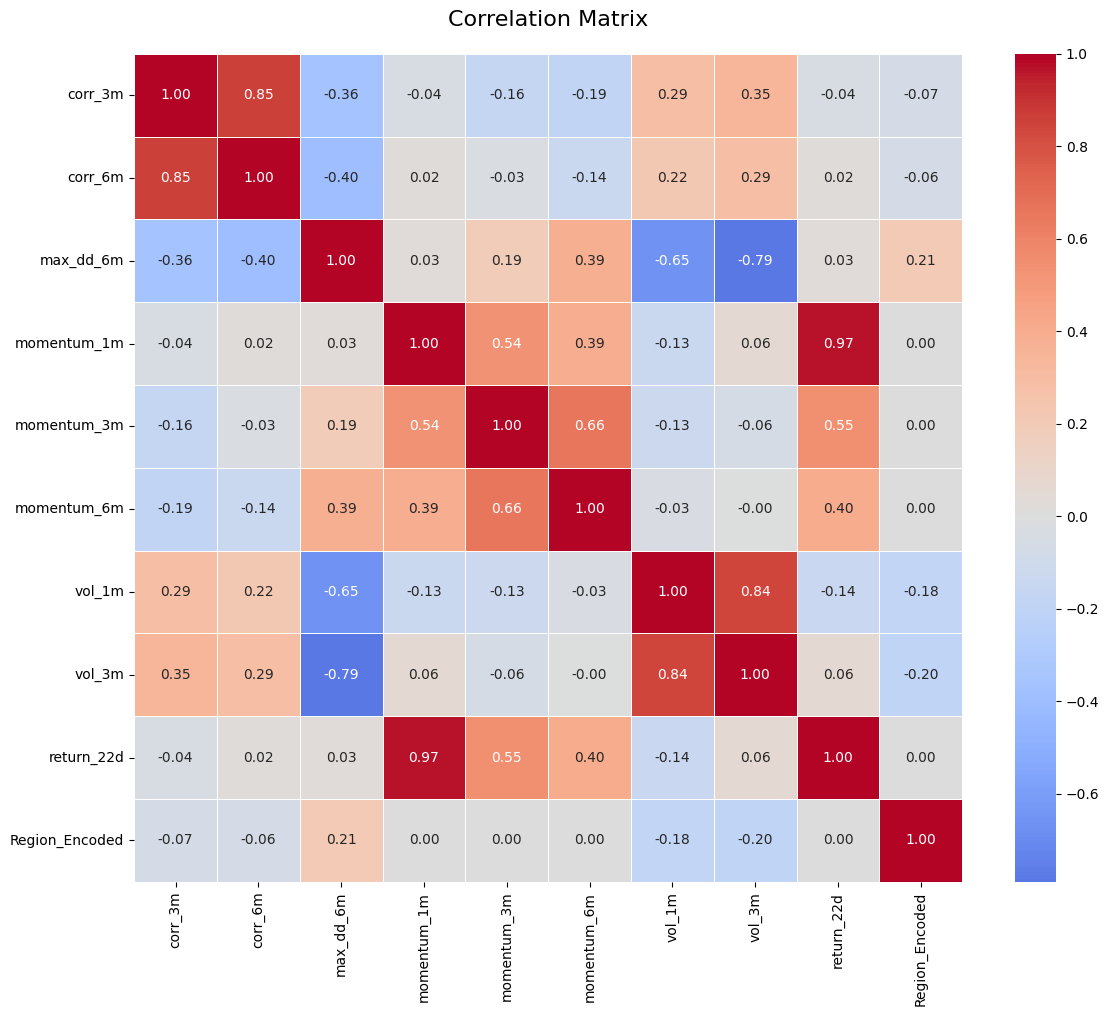

Corrélations élevées (|r| > 0.7):
  Feature 1  Feature 2  Correlation
momentum_1m return_22d     0.971907
    corr_3m    corr_6m     0.853686
     vol_1m     vol_3m     0.839420
  max_dd_6m     vol_3m    -0.791011


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = numeric_features + ['return_22d', 'Region_Encoded']
correlation_matrix = df1[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr:
    print("Corrélations élevées (|r| > 0.7):")
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("Aucune corrélation élevée trouvée")

In [30]:
df1.drop(columns=["vol_3m","corr_6m", "Region (General)_x"], inplace=True)

In [31]:
df1.set_index(['Date', 'Ticker'], inplace=True)

In [32]:
df1

corr_3m  max_dd_6m  momentum_1m  momentum_3m  momentum_6m  \
Date       Ticker                                                               
2016-06-21 FXU    -0.739536   0.567378     0.509733     0.033906     0.852074   
           GUNR    0.114184  -0.448420     0.394455     0.220185     0.843712   
           IYW    -0.656653  -0.310588     0.120900    -0.371868    -0.293461   
           LIT    -0.046498  -0.431322     0.994789     1.092123     1.343227   
           NANR   -0.283431  -0.643883     0.384666     0.760388     1.671699   
...                     ...        ...          ...          ...          ...   
2026-01-15 PSI     0.473724  -0.164123     2.154613     1.907352     2.444639   
           PTLC    0.313417   0.651727     0.100930     0.076708     0.251915   
           RING   -0.001647  -0.797529     1.916219     1.407599     4.908992   
           UTES   -0.174856  -0.079584     0.285919    -0.795792     0.253170   
           XCEM    0.400437   0.678203     1.274039     0.735373     0.829321   

                   return_22d    vol_1m  Region_Encoded  
Date       Ticker                                        
2016-06-21 FXU       0.054488 -0.724951               2  
           GUNR      0.044930 -0.049553               0  
           IYW       0.036096 -0.558646               2  
           LIT       0.096245 -0.037726               0  
           NANR      0.046489  0.020417               2  
...                       ...       ...             ...  
2026-01-15 PSI       0.163208  1.152634               2  
           PTLC      0.020101 -0.754131               2  
           RING      0.148608  1.348427               0  
           UTES      0.039743  0.489773               2  
           XCEM      0.104418 -0.473180               1  

[28884 rows x 8 columns]

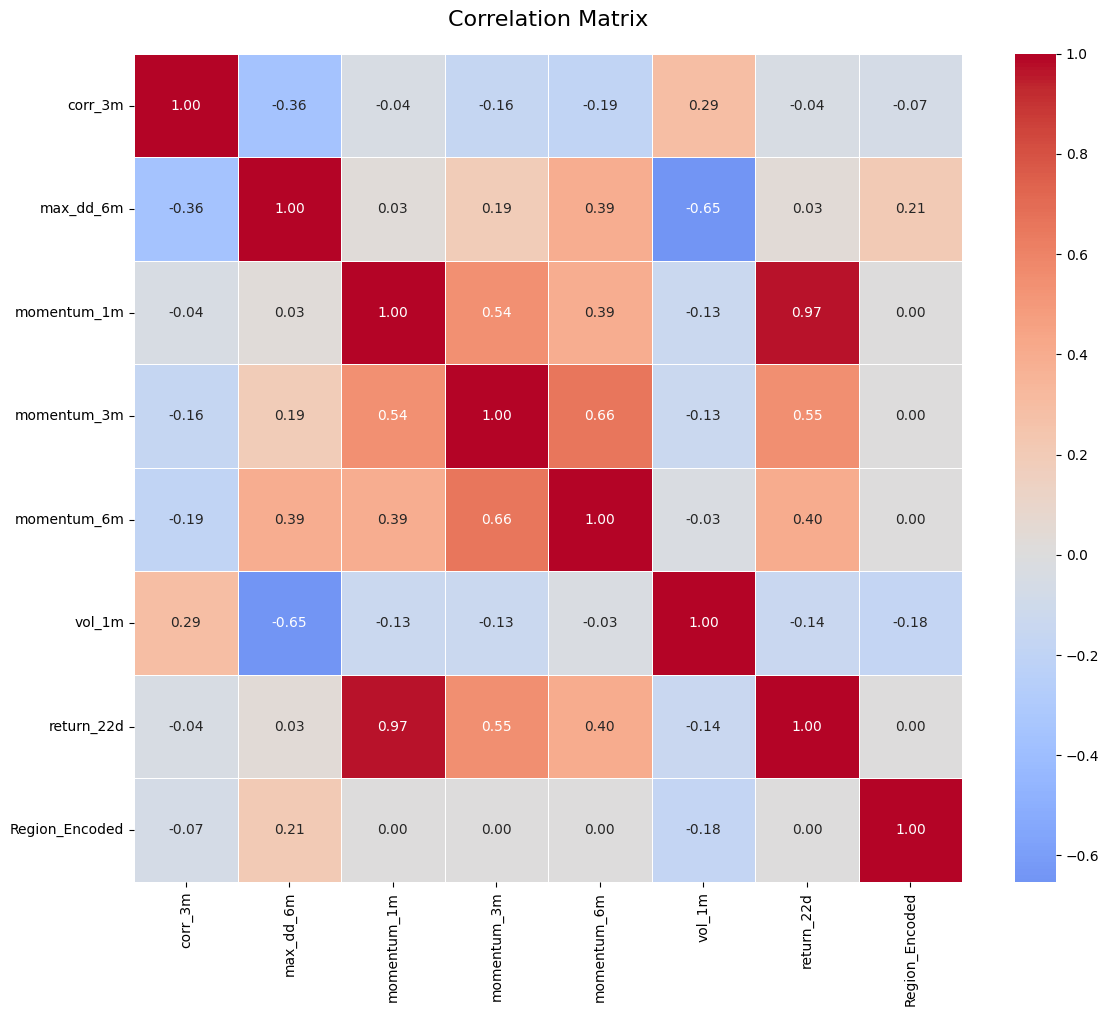

Corrélations élevées (|r| > 0.7):
  Feature 1  Feature 2  Correlation
momentum_1m return_22d     0.971907


In [33]:
numeric_features = ['corr_3m', 'max_dd_6m', 'momentum_1m', 'momentum_3m', 'momentum_6m', 'vol_1m']
numeric_cols = numeric_features + ['return_22d', 'Region_Encoded']
correlation_matrix = df1[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

high_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': corr_val
            })

if high_corr:
    print("Corrélations élevées (|r| > 0.7):")
    high_corr_df = pd.DataFrame(high_corr).sort_values('Correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
else:
    print("Aucune corrélation élevée trouvée")

# Forecasting

In [34]:
import tensorflow as tf
from tf_keras.models import Sequential
from tf_keras.layers import LSTM, Dense, Dropout
from tf_keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [35]:
df_model = df1.reset_index()
df_model = df_model.sort_values(['Ticker', 'Date'])
df_model

,Date,Ticker,corr_3m,max_dd_6m,momentum_1m,momentum_3m,momentum_6m,return_22d,vol_1m,Region_Encoded
0,2016-06-21,FXU,-0.739536,0.567378,0.509733,0.033906,0.852074,0.054488,-0.724951,2
12,2016-06-22,FXU,-0.714832,0.567378,0.570620,-0.011651,0.774318,0.045380,-0.765493,2
24,2016-06-23,FXU,-0.650249,0.567378,0.535635,0.017167,0.773920,0.063147,-0.783815,2
36,2016-06-24,FXU,-0.538724,0.567378,0.396218,-0.072483,0.561859,0.040907,-0.701286,2
48,2016-06-27,FXU,-0.688733,0.567378,0.263591,-0.222430,0.572684,0.042955,-0.735474,2
...,...,...,...,...,...,...,...,...,...,...
28835,2026-01-09,XCEM,0.720747,0.678203,0.887615,0.693278,0.813628,0.083146,-0.357318,1
28847,2026-01-12,XCEM,0.612892,0.678203,0.827452,1.013788,0.857116,0.084878,-0.372288,1
28859,2026-01-13,XCEM,0.408328,0.678203,0.846086,0.699757,0.804008,0.067163,-0.380240,1
28871,2026-01-14,XCEM,0.417953,0.678203,1.133744,0.848263,0.810149,0.081605,-0.469632,1


In [36]:
def create_sequences_with_info(data, seq_length=10):
    X, y = [], []
    info = []

    for ticker in data['Ticker'].unique():
        ticker_data = data[data['Ticker'] == ticker].sort_values('Date')
        features = ticker_data[['corr_3m', 'max_dd_6m', 'momentum_1m',
                                'momentum_3m', 'momentum_6m', 'vol_1m',
                                'Region_Encoded']].values
        target = ticker_data['return_22d'].values
        dates = ticker_data['Date'].values

        for i in range(len(features) - seq_length):
            X.append(features[i:i+seq_length])
            y.append(target[i+seq_length])
            info.append({'ticker': ticker, 'date': dates[i+seq_length]})

    return np.array(X), np.array(y), pd.DataFrame(info)

## Train_Val_Test Split by Ticker

In [37]:
# Stratified split by ticker: 80% train, 20% test for each ticker
X_train_final, X_val = [], []
y_train_final, y_val = [], []
X_test, y_test = [], []
info_train_final, info_val, test_info = [], [], []

for ticker in df_model['Ticker'].unique():
    ticker_data = df_model[df_model['Ticker'] == ticker].sort_values('Date')

    # Get sequences for this ticker
    ticker_X, ticker_y, ticker_info = create_sequences_with_info(
        ticker_data.reset_index(drop=True),
        seq_length=10
    )

    # Split: 80% train, 20% test
    split_idx = int(len(ticker_X) * 0.8)
    train_X, test_X_ticker = ticker_X[:split_idx], ticker_X[split_idx:]
    train_y, test_y_ticker = ticker_y[:split_idx], ticker_y[split_idx:]
    train_info, test_info_ticker = ticker_info.iloc[:split_idx], ticker_info.iloc[split_idx:]

    # Further split training data: 80% train_final, 20% validation
    val_split_idx = int(len(train_X) * 0.8)
    X_train_final.append(train_X[:val_split_idx])
    X_val.append(train_X[val_split_idx:])
    y_train_final.append(train_y[:val_split_idx])
    y_val.append(train_y[val_split_idx:])
    info_train_final.append(train_info.iloc[:val_split_idx])
    info_val.append(train_info.iloc[val_split_idx:])

    # Append test data
    X_test.append(test_X_ticker)
    y_test.append(test_y_ticker)
    test_info.append(test_info_ticker)

# Concatenate all tickers
X_train_final = np.concatenate(X_train_final)
X_val = np.concatenate(X_val)
X_test = np.concatenate(X_test)
y_train_final = np.concatenate(y_train_final)
y_val = np.concatenate(y_val)
y_test = np.concatenate(y_test)
info_train_final = pd.concat(info_train_final, ignore_index=True)
info_val = pd.concat(info_val, ignore_index=True)
test_info = pd.concat(test_info, ignore_index=True)

print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Training set: {len(info_train_final)} échantillons")
print(f"Validation set: {len(info_val)} échantillons")
print(f"Test set: {len(test_info)} échantillons")

X_train_final shape: (18396, 10, 7)
X_val shape: (4608, 10, 7)
X_test shape: (5760, 10, 7)
Training set: 18396 échantillons
Validation set: 4608 échantillons
Test set: 5760 échantillons


## Verification du nombre de tickers par split

In [38]:
# Compter par split
for name, info in [("TRAIN Split", info_train_final), ("VAL Split", info_val), ("TEST Split", test_info)]:
    print(f"\n{name}:")
    print(info['ticker'].value_counts().sort_index())


TRAIN Split:
ticker
FXU     1533
GUNR    1533
IYW     1533
LIT     1533
NANR    1533
NLR     1533
PICK    1533
PSI     1533
PTLC    1533
RING    1533
UTES    1533
XCEM    1533
Name: count, dtype: int64

VAL Split:
ticker
FXU     384
GUNR    384
IYW     384
LIT     384
NANR    384
NLR     384
PICK    384
PSI     384
PTLC    384
RING    384
UTES    384
XCEM    384
Name: count, dtype: int64

TEST Split:
ticker
FXU     480
GUNR    480
IYW     480
LIT     480
NANR    480
NLR     480
PICK    480
PSI     480
PTLC    480
RING    480
UTES    480
XCEM    480
Name: count, dtype: int64


# Model 1

In [39]:
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(10, 7)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 10, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 31851 (124.42 KB)
Trainable params: 31851 (124.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1150/1150 [==============================] - 15s 5ms/step - loss: 0.0012 - mae: 0.0242 - val_loss: 5.9438e-04 - val_mae: 0.0184
Epoch 2/50
1150/1150 [==============================] - 4s 4ms/step - loss: 5.6674e-04 - mae: 0.0168 - val_loss: 4.2333e-04 - val_mae: 0.0159
Epoch 3/50
1150/1150 [==============================] - 5s 4ms/step - loss: 4.5959e-04 - mae: 0.0150 - val_loss: 4.0491e-04 - val_mae: 0.0155
Epoch 4/50
1150/1150 [==============================] - 4s 4ms/step - loss: 4.2673e-04 - mae: 0.0144 - val_loss: 4.3392e-04 - val_mae: 0.0161
Epoch 5/50
1150/1150 [==============================] - 4s 4ms/step - loss: 4.1391e-04 - mae: 0.0141 - val_loss: 2.7520e-04 - val_mae: 0.0123
Epoch 6/50
1150/1150 [==============================] - 4s 4ms/step - loss: 3.8988e-04 - mae: 0.0137 - val_loss: 3.0152e-04 - val_mae: 0.0131
Epoch 7/50
1150/1150 [==============================] - 4s 4ms/step - loss: 4.0579e-04 - mae: 0.0137 - val_loss: 3.1565e-04 - val_mae: 0.0136
Epoch 8/5

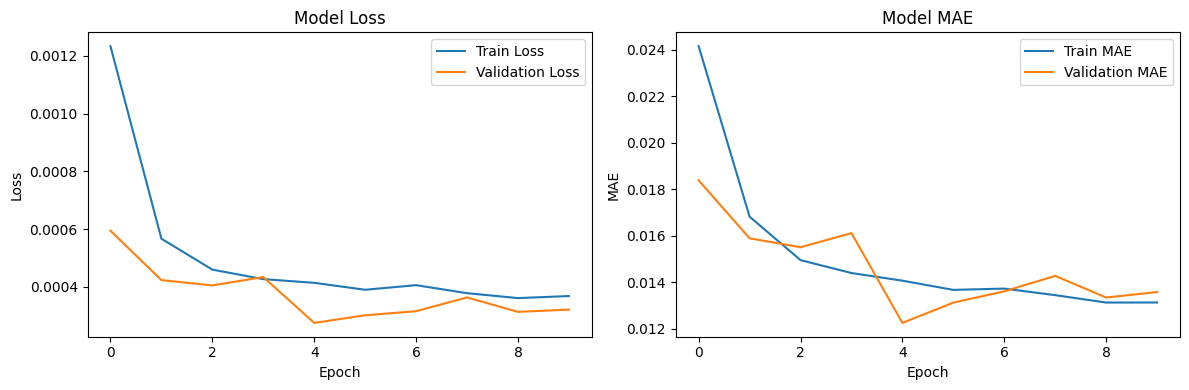

In [41]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

Test Loss: 0.000344
Test MAE: 0.013135


# Modele 2 (Kawtar)

In [49]:

from tf_keras import layers, regularizers
import tf_keras as keras
from tf_keras.layers import Flatten



def build_model():
    model = keras.Sequential()
    model.add(keras.Input(shape=(10, 7)))
    model.add(Flatten())
    model.add(layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

In [50]:
model2 = build_model()
model2.summary()

X_train_final.shape

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 70)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               18176     
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                     

(18396, 10, 7)

In [51]:
history2 = model2.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Epoch 1/50
1150/1150 [==============================] - 3s 1ms/step - loss: 0.4254 - mae: 0.1907 - val_loss: 0.2971 - val_mae: 0.0475
Epoch 2/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.2375 - mae: 0.0626 - val_loss: 0.1684 - val_mae: 0.0348
Epoch 3/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.1144 - mae: 0.0415 - val_loss: 0.0662 - val_mae: 0.0316
Epoch 4/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0386 - mae: 0.0339 - val_loss: 0.0179 - val_mae: 0.0241
Epoch 5/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0107 - mae: 0.0318 - val_loss: 0.0056 - val_mae: 0.0309
Epoch 6/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0057 - mae: 0.0338 - val_loss: 0.0035 - val_mae: 0.0227
Epoch 7/50
1150/1150 [==============================] - 1s 1ms/step - loss: 0.0046 - mae: 0.0320 - val_loss: 0.0034 - val_mae: 0.0237
Epoch 8/50
1150/1150 [==============================] - 1s 1ms

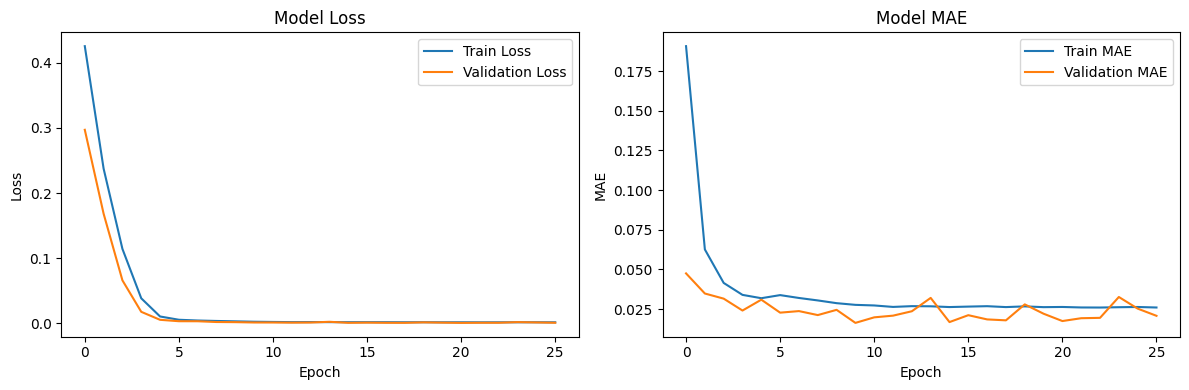

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['mae'], label='Train MAE')
plt.plot(history2.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

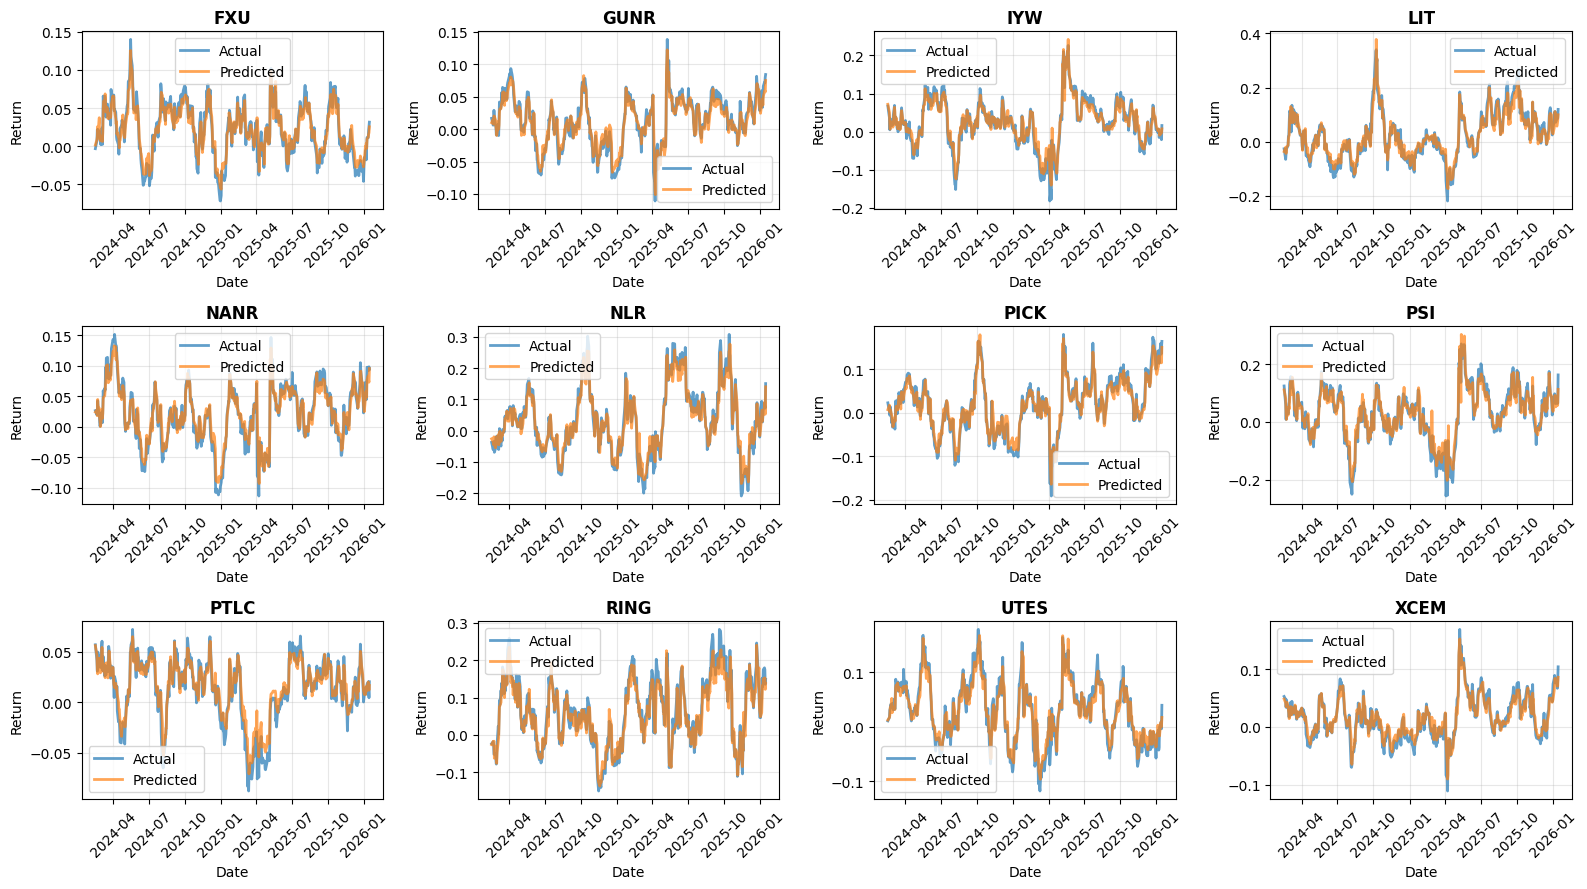

In [53]:
# Get predictions from model2
y_pred = model.predict(X_test, verbose=0)

# Add predictions and actual values to test_info
test_info['actual'] = y_test
test_info['predicted'] = y_pred.flatten()

# Create subplots for each ticker
tickers_list = test_info['ticker'].unique()
n_tickers = len(tickers_list)
n_cols = 4
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(tickers_list)):
    ticker_data = test_info[test_info['ticker'] == ticker].sort_values('date')

    axes[idx].plot(ticker_data['date'], ticker_data['actual'], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(ticker_data['date'], ticker_data['predicted'], label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_title(f'{ticker}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Return')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Hide empty subplots
for idx in range(n_tickers, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

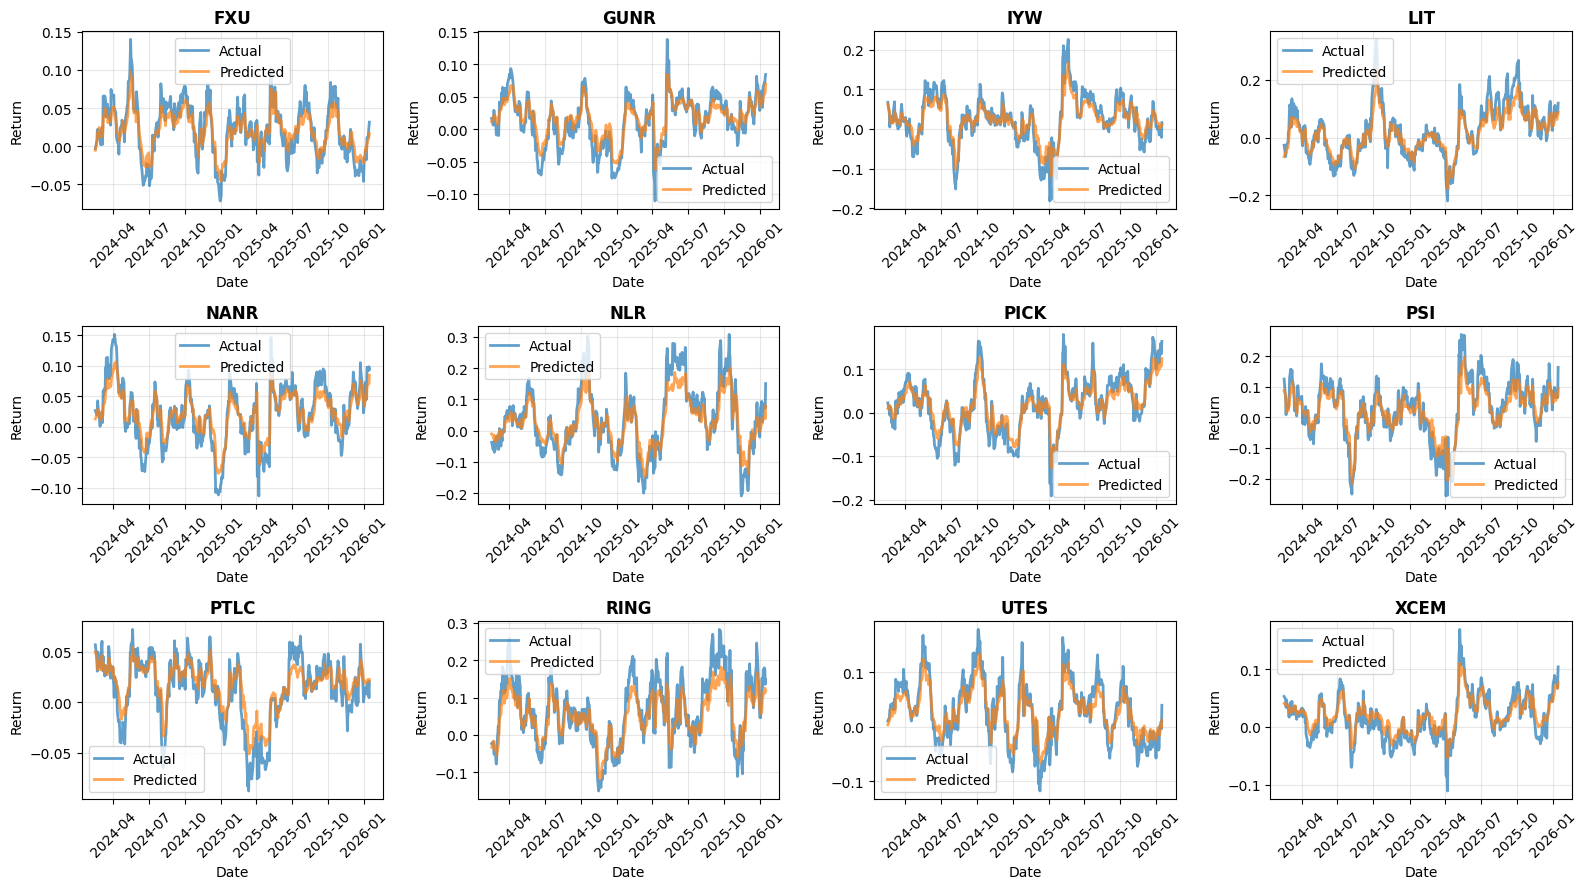

In [54]:
# Get predictions from model2
y_pred = model2.predict(X_test, verbose=0)

# Add predictions and actual values to test_info
test_info['actual'] = y_test
test_info['predicted'] = y_pred.flatten()

# Create subplots for each ticker
tickers_list = test_info['ticker'].unique()
n_tickers = len(tickers_list)
n_cols = 4
n_rows = (n_tickers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3*n_rows))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(tickers_list)):
    ticker_data = test_info[test_info['ticker'] == ticker].sort_values('date')

    axes[idx].plot(ticker_data['date'], ticker_data['actual'], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(ticker_data['date'], ticker_data['predicted'], label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_title(f'{ticker}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('Return')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Hide empty subplots
for idx in range(n_tickers, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

Optimization

In [63]:
pred_df = (
    test_info
    .pivot(index="date", columns="ticker", values="predicted")
    .sort_index()
)

In [64]:
pred_df.head()

ticker,FXU,GUNR,IYW,LIT,NANR,NLR,PICK,PSI,PTLC,RING,UTES,XCEM
date,,,,,,,,,,,,
2024-02-16,-0.005361,0.011328,0.061936,-0.065964,0.012485,-0.010417,0.010154,0.087154,0.049486,-0.033446,0.003800,0.040705
2024-02-20,0.006277,0.016124,0.046243,-0.050208,0.018864,-0.017756,0.017130,0.072671,0.044156,-0.023206,0.011717,0.038948
2024-02-21,0.011079,0.014301,0.026737,-0.053980,0.016485,-0.025253,0.011737,0.037025,0.035012,-0.020113,0.014445,0.037317
2024-02-22,0.018398,0.021386,0.015513,-0.040962,0.028108,-0.013710,0.013767,0.018180,0.032202,-0.016974,0.022023,0.037764
2024-02-23,0.017134,0.021676,0.024454,-0.039714,0.024838,-0.028930,0.011861,0.030381,0.039101,-0.041126,0.022548,0.039933


In [65]:
selected_etfs = ["FXU", "GUNR", "LIT"]

In [66]:
pred_df_3 = pred_df[selected_etfs].dropna()

In [81]:
def optimize_portfolio_with_cvar_constraint(tickers, returns, alpha=0.99, portfolio_cvar_threshold=-0.07):
    returns_array = returns.values
    n_assets = returns_array.shape[1]

    initial_weights = np.ones(n_assets) / n_assets

    def portfolio_returns(weights):
        return returns_array @ weights

    def portfolio_cvar(weights):
        pr = portfolio_returns(weights)
        cutoff = np.percentile(pr, (1 - alpha) * 100)
        return pr[pr <= cutoff].mean()

    def objective(weights):
        return -np.mean(portfolio_returns(weights))

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},  # weights = 100%
        {"type": "ineq", "fun": lambda w: portfolio_cvar(w) - portfolio_cvar_threshold}
    ]

    bounds = [(0, 1) for _ in range(n_assets)]

    result = minimize(
        objective,
        initial_weights,
        method="SLSQP",
        bounds=bounds,
        constraints=constraints
    )

    if not result.success:
        raise ValueError("CVaR optimization failed")

    return pd.Series(result.x, index=tickers)


In [82]:
def calculate_cumulative_returns(returns):
    return (1 + returns).cumprod()


def calculate_summary_stats(returns):
    annual_return = (1 + returns).prod() ** (252 / len(returns)) - 1
    annual_volatility = returns.std() * np.sqrt(252)
    return annual_return, annual_volatility

In [83]:
selected_etfs = ["FXU", "GUNR", "LIT"]

In [84]:
pred_df_3 = pred_df[selected_etfs].dropna()

In [88]:
cvar_weights = optimize_portfolio_with_cvar_constraint(
    tickers=selected_etfs,
    returns=pred_df_3,
    alpha=0.99,
    portfolio_cvar_threshold=-0.05)

cvar_returns = pred_df_3.dot(cvar_weights)